## Set Up Dependencies


In [1]:
import datetime
import os

from cliffs_delta import cliffs_delta
import pandas as pd
import pecking
import matplotlib as mpl
from matplotlib import pyplot as plt
import pecking
import seaborn as sns
from slugify import slugify
from teeplot import teeplot as tp

from pylib._describe_effect import describe_effect
from pylib._styler_to_pdf import styler_to_pdf


## Data Retrieval and Preprocessing


In [2]:
df = pd.read_parquet("https://osf.io/ah7v5/download")


In [3]:
df["Num Reconstructed Inner Nodes"] = df["num_reconstructed_inner_nodes"]
df["Num True Inner Nodes"] = df["num_true_inner_nodes"]
df["Raw Triplet Distance"] = df["triplet_distance_raw"]
df["Sampled Triplet Distance Strict Reconst"] = df[
    "sampled_triplet_distance_strict_reconst"
]
df["Strict Triplet Distance"] = df["sampled_triplet_distance_strict"]
df["Lax Triplet Distance"] = df["sampled_triplet_distance_lax"]
df["Differentia Width (bits)"] = df["differentia_width_bits"]
df["Annotation Size (bits)"] = df["annotation_size_bits"]
df["Algorithm"] = df["algorithm"]
df["Population Size"] = df["population_size"]
df["Num Generations"] = df["num_generations"]
df["Num Islands"] = df["num_islands"]
df["Num Niches"] = df["num_niches"]
df["Tournament Size"] = df["tournament_size"]
df["Replicate"] = df["replicate"]
df["Downsample"] = df["downsample"]


In [4]:
df = df[df["Annotation Size (bits)"] == 256].copy()


In [5]:
df["Inner Node Resolution"] = (
    df["Num Reconstructed Inner Nodes"] / df["Num True Inner Nodes"]
)
df["Inner Node Loss"] = 1 - df["Inner Node Resolution"]


In [6]:
df["Dynamics"] = (
    "islands"
    + df["Num Islands"].astype(str)
    + "-niches"
    + df["Num Niches"].astype(str)
    + "-tsize"
    + df["Tournament Size"].astype(str)
)


In [7]:
df["Scale"] = (
    "npop"
    + df["Population Size"].astype(str)
    + "-ngen"
    + df["Num Generations"].astype(str)
)


In [8]:
df["Scenario"] = df["Dynamics"].map(
    {
        "islands1-niches1-tsize2": "plain",
        "islands1-niches1-tsize1": "drift",
        "islands4-niches2-tsize2": "mild\nstructure",
        "islands64-niches8-tsize2": "rich\nstructure",
    }
)


In [9]:
df["Policy"] = df["Algorithm"].map(
    {
        "surf-tilted": "Tilted",
        "col-tilted": "Tilted",
        "surf-hybrid": "Hybrid",
        "surf-steady": "Steady",
        "col-steady": "Steady",
    }
)


In [10]:
df["Implementation"] = df["Algorithm"].map(
    {
        "surf-tilted": "Surface",
        "col-tilted": "Column",
        "surf-hybrid": "Surface",
        "surf-steady": "Surface",
        "col-steady": "Column",
    }
)


In [11]:
for col in df.columns:
    df[col.replace(" ", "\n")] = df[col]


In [12]:
sensitivity_analysis_variables = [
    "Population\nSize",
    "Downsample",
    "Num\nGenerations",
]


In [13]:
dfx = df.melt(
    id_vars=[
        "Algorithm",
        "Annotation Size (bits)",
        "Annotation\nSize\n(bits)",
        "annotation_size_bits",
        "Differentia Width (bits)",
        "Differentia\nWidth\n(bits)",
        "differentia_width_bits",
        "Downsample",
        "downsample",
        "Dynamics",
        "Implementation",
        "Policy",
        "Scenario",
        "Scale",
        "Population Size",
        "Population\nSize",
        "population_size",
        "Num Generations",
        "Num\nGenerations",
        "num_generations",
        "Num Islands",
        "Num Niches",
        "Tournament Size",
        "Replicate",
    ],
    value_vars=[
        # "Strict\nTriplet\nDistance",
        "Lax\nTriplet\nDistance",
        "Inner\nNode\nLoss",
    ],
)
dfx.head()


,Algorithm,Annotation Size (bits),Annotation\nSize\n(bits),annotation_size_bits,Differentia Width (bits),Differentia\nWidth\n(bits),differentia_width_bits,Downsample,downsample,Dynamics,...,population_size,Num Generations,Num\nGenerations,num_generations,Num Islands,Num Niches,Tournament Size,Replicate,variable,value
0,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,4,Lax\nTriplet\nDistance,0.0
1,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,12,Lax\nTriplet\nDistance,0.0
2,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,2,Lax\nTriplet\nDistance,0.0
3,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,19,Lax\nTriplet\nDistance,0.0
4,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,1,Lax\nTriplet\nDistance,0.0


## Visualize Main Metrics


/home/runner/.local/lib/python3.12/site-packages/pecking/_skim_lowest.py:184: UserWarning: ValueError `All numbers are identical in kruskal` ocurred. No groups skimmed.
  warnings.warn(f"ValueError `{e}` ocurred. No groups skimmed.")


/home/runner/.local/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/col=policy+downsample=500+hue=chkpt-num-bits+num-generations=10000+population-size=4096+row=variable+score=value+viz=peckplot+x=evolutionary-scenario+x-group=outer+y=value+ext=.pdf


teeplots/col=policy+downsample=500+hue=chkpt-num-bits+num-generations=10000+population-size=4096+row=variable+score=value+viz=peckplot+x=evolutionary-scenario+x-group=outer+y=value+ext=.png


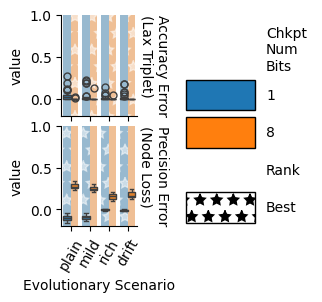

{'Population\nSize': 4096, 'Downsample': 500, 'Num\nGenerations': 10000}

/home/runner/.local/lib/python3.12/site-packages/pecking/_skim_lowest.py:184: UserWarning: ValueError `All numbers are identical in kruskal` ocurred. No groups skimmed.
  warnings.warn(f"ValueError `{e}` ocurred. No groups skimmed.")


/home/runner/.local/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/col=policy+downsample=500+hue=chkpt-num-bits+num-generations=100000+population-size=4096+row=variable+score=value+viz=peckplot+x=evolutionary-scenario+x-group=outer+y=value+ext=.pdf


teeplots/col=policy+downsample=500+hue=chkpt-num-bits+num-generations=100000+population-size=4096+row=variable+score=value+viz=peckplot+x=evolutionary-scenario+x-group=outer+y=value+ext=.png


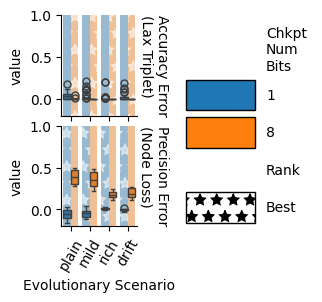

{'Population\nSize': 4096, 'Downsample': 500, 'Num\nGenerations': 100000}

/home/runner/.local/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/col=policy+downsample=500+hue=chkpt-num-bits+num-generations=10000+population-size=65536+row=variable+score=value+viz=peckplot+x=evolutionary-scenario+x-group=outer+y=value+ext=.pdf


teeplots/col=policy+downsample=500+hue=chkpt-num-bits+num-generations=10000+population-size=65536+row=variable+score=value+viz=peckplot+x=evolutionary-scenario+x-group=outer+y=value+ext=.png


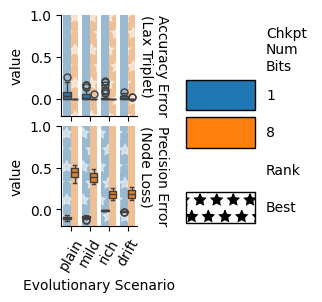

{'Population\nSize': 65536, 'Downsample': 500, 'Num\nGenerations': 10000}

/home/runner/.local/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/col=policy+downsample=500+hue=chkpt-num-bits+num-generations=100000+population-size=65536+row=variable+score=value+viz=peckplot+x=evolutionary-scenario+x-group=outer+y=value+ext=.pdf
teeplots/col=policy+downsample=500+hue=chkpt-num-bits+num-generations=100000+population-size=65536+row=variable+score=value+viz=peckplot+x=evolutionary-scenario+x-group=outer+y=value+ext=.png


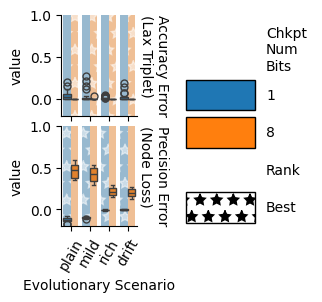

{'Population\nSize': 65536, 'Downsample': 500, 'Num\nGenerations': 100000}

/home/runner/.local/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/col=policy+downsample=8000+hue=chkpt-num-bits+num-generations=10000+population-size=65536+row=variable+score=value+viz=peckplot+x=evolutionary-scenario+x-group=outer+y=value+ext=.pdf


teeplots/col=policy+downsample=8000+hue=chkpt-num-bits+num-generations=10000+population-size=65536+row=variable+score=value+viz=peckplot+x=evolutionary-scenario+x-group=outer+y=value+ext=.png


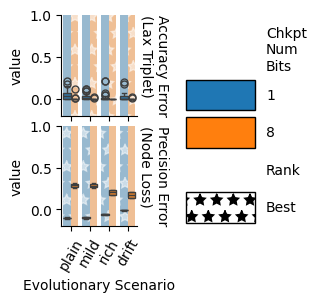

{'Population\nSize': 65536, 'Downsample': 8000, 'Num\nGenerations': 10000}

/home/runner/.local/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/col=policy+downsample=8000+hue=chkpt-num-bits+num-generations=100000+population-size=65536+row=variable+score=value+viz=peckplot+x=evolutionary-scenario+x-group=outer+y=value+ext=.pdf
teeplots/col=policy+downsample=8000+hue=chkpt-num-bits+num-generations=100000+population-size=65536+row=variable+score=value+viz=peckplot+x=evolutionary-scenario+x-group=outer+y=value+ext=.png


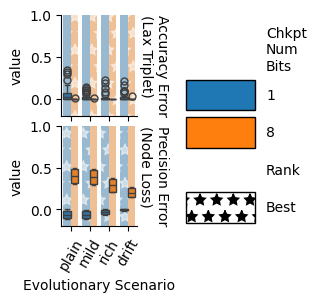

{'Population\nSize': 65536, 'Downsample': 8000, 'Num\nGenerations': 100000}

In [14]:
for name, group in dfx.groupby(sensitivity_analysis_variables):
    group_variables = dict(zip(sensitivity_analysis_variables, name))

    group["Evolutionary Scenario"] = group["Scenario"].apply(
        lambda x: x.split("\n")[0],
    )
    group["variable"] = group["variable"].str.replace(
        "Lax\nTriplet\nDistance",
        "Accuracy Error\n(Lax Triplet)",
    ).str.replace(
        "Inner\nNode\nLoss",
        "Precision Error\n(Node Loss)",
    )
    group["Chkpt\nNum\nBits"] = group["Differentia\nWidth\n(bits)"]
    row_order = [
        # "Strict\nTriplet\nDistance",
        "Accuracy Error\n(Lax Triplet)",
        "Precision Error\n(Node Loss)",
    ]

    with tp.teed(
        pecking.peckplot,
        data=group.reset_index(drop=True).rename(
            columns={"Implementation": "Impl"},
        ),
        score="value",
        x="Evolutionary Scenario",
        y="value",
        # col="Num Generations",
        col="Policy",
        col_order=[
            "Tilted",
            # "Hybrid",
            # "Steady",
        ],
        row="variable",
        row_order=row_order,
        hue="Chkpt\nNum\nBits",
        x_group="outer",
        order=[
            "plain",
            "mild",
            "rich",
            "drift",
        ],
        skim_hatches=("*",),
        skim_labels=("Best",),
        skimmers=[pecking.skim_lowest],
        margin_titles=True,
        height=1.6,
        aspect=1.6,
        facet_kws={
            "ylim": (-0.2, 1),
        },
        teeplot_outattrs={
            slugify(k): str(v) for k, v in group_variables.items()
        },
        # clip_on=False,
    ) as teed:
        teed.set_titles(
            col_template="",
            row_template="{row_name}",
        )
        plt.tight_layout()
        teed.figure.subplots_adjust(right=0.41)
        teed.figure.subplots_adjust(hspace=0.1)
        for ax in teed.axes.flat:
            plt.setp(ax.get_xticklabels(), rotation=60)

    display(group_variables)


## Reproducibility


In [15]:
datetime.datetime.now().isoformat()


'2025-03-17T10:28:23.845714'

In [16]:
%load_ext watermark
%watermark


Last updated: 2025-03-17T10:28:23.857377+00:00

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.22.1

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-1021-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



In [17]:
!pip freeze


aiohttp==3.9.0b0
aiosignal==1.3.2
alifedata-phyloinformatics-convert==0.16.2
annotated-types==0.6.0
anytree==2.12.1
appdirs==1.4.4
argcomplete==3.6.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
asttokens==2.4.1
attrs==23.2.0
Automat==22.10.0
Babel==2.10.3
backstrip==0.2.4
bcc==0.29.1
bcrypt==3.2.2
beautifulsoup4==4.12.3
biopython==1.83
bitarray==2.9.2
bitstring==4.1.4
black==22.10.0
bleach==6.1.0
blinker==1.7.0
boto3==1.34.46
botocore==1.34.46
Brotli==1.1.0
CacheControl==0.14.0
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
click==8.1.7
cliffs-delta==1.0.0
cloud-init==24.4
colorama==0.4.6
colorclade==0.2.0
comm==0.2.1
command-not-found==0.3
configobj==5.0.8
constantly==23.10.4
contourpy==1.2.0
cryptography==41.0.7
cssselect==1.2.0
cssselect2==0.7.0
cycler==0.12.1
dataclasses==0.6
dbus-python==1.3.2
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
DendroPy==4.6.1
Deprecated==1.2.14
distro==1.9.0
distro-info==1.7+build1
distutils-strtobool==0.1.0
entrypoint